In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as hac

import pandas

import glob
import struct
from collections import Counter

# Расшифровка протокола VHome

In [2]:
# takes filename
# open file, read binary data
# returns numpy.array of impulses (positive integer)
# and pauses (negative integer)
def file_to_data(filename):
    pic = open(filename, "rb")
    data = []
    while True:
        buf = pic.read(4)
        if not buf or len(buf) != 4:
            break
        sign = 1 if buf[3] == 1 else -1
        buf = bytes(buf[:3] + bytes([0]))
        data.append(sign * struct.unpack('i', buf)[0])
    return np.array(data)

# takes files' mask
# returns numpy.array of data
def files_to_data(mask):
    # откуда брать дампы
    filenames = sorted(glob.glob(mask))
    
    print("%d files found" % len(filenames))

    datas = []

    # посмотрим файлики с дампами, преобразуем в импульсы
    for name in filenames:
        print("read " + name)
        datas.append(file_to_data(name))

    return np.concatenate(datas)


In [3]:
# читаем информацию
data = files_to_data("./*.rcf")

4 files found
read ./EV1527_remoteABCD_keyA.rcf
read ./EV1527_remoteABCD_keyB.rcf
read ./EV1527_remoteABCD_keyC.rcf
read ./EV1527_remoteABCD_keyD.rcf


In [11]:
print(list(data[:]))

[-6725, 902225, -1044, 978, -398, 287, -1072, 1013, -402, 972, -427, 962, -399, 286, -1078, 297, -1089, 300, -1055, 276, -1088, 1005, -368, 1040, -367, 319, -1056, 1007, -391, 297, -1055, 1014, -374, 329, -1048, 316, -1056, 1008, -365, 317, -1062, 333, -1041, 307, -10637, 997, -366, 1020, -367, 309, -1053, 318, -1056, 1008, -367, 320, -1055, 1008, -418, 974, -382, 992, -383, 326, -1096, 290, -1071, 303, -1071, 304, -1071, 984, -409, 1000, -359, 303, -1071, 1002, -429, 261, -1114, 955, -412, 266, -1108, 259, -1124, 990, -376, 299, -1085, 279, -1070, 303, -10631, 971, -413, 992, -400, 288, -1070, 303, -1097, 967, -399, 288, -1091, 983, -420, 974, -367, 1008, -399, 288, -1087, 287, -1088, 328, -1049, 318, -1055, 1021, -356, 1007, -367, 319, -1079, 1042, -360, 310, -1065, 1006, -353, 318, -1056, 329, -1074, 996, -400, 303, -1054, 287, -1088, 287, -10633, 998, -406, 1002, -383, 332, -1037, 294, -1074, 1007, -367, 300, -1103, 992, -384, 991, -416, 984, -391, 271, -1125, 261, -1113, 254, -112

Посмотрим на гистограммы длин импульсов и пауз

In [5]:
# show histogramm of lengthes
# ignore lengthes that is greater than (1 - threshold) quantile
def show_hist(data, title, threshold=0.02):
    k = int(len(data) * (1 - threshold))
    data = np.partition(data, k)[:k]
    
    plt.hist(data, bins = 100)
    plt.title(title)
    plt.xlim([0, data.max() * 1.1])
    plt.show()

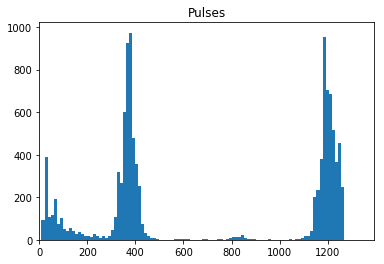

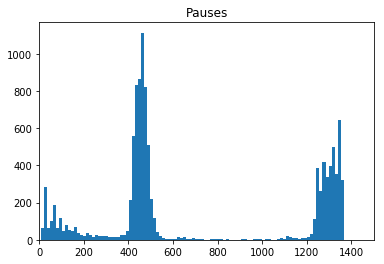

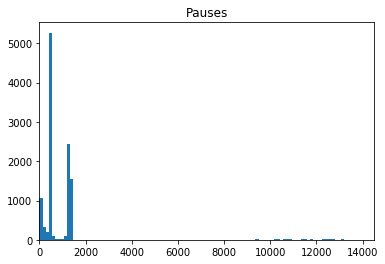

In [316]:
show_hist(data[data > 0], "Pulses", threshold=0.05)
show_hist(-data[data < 0], "Pauses", threshold=0.05)
show_hist(-data[data < 0], "Pauses", threshold=0.01) # обращаем внимание на непримечательный пик справа

In [17]:
groups = [
    ('A', 1, 600, 3000),
    ('B', 600, 1400, 1300),
    ('a', -800, -1, 3000),
    ('b', -1400, -800, 1300),
    ('c', -20000, -2000, 20)
]

In [18]:
# All the same but in a table
data_frame = pandas.DataFrame([(lower, upper, count) for letter, lower, upper, count in groups], 
                              index=[letter for letter, lower, upper, count in groups],
            
                              columns=['Lower length', 'Upper length', 'count of signals'])
data_frame.insert(1, "Type", ["impulse" if lower > 0 else "pause" for c, lower, upper, count in groups])
data_frame = data_frame.sort_index()
#data_frame = data_frame.pivot_table(index='Letter')
data_frame

,Lower length,Type,Upper length,count of signals
A,1,impulse,600,3000
B,600,impulse,1400,1300
a,-800,pause,-1,3000
b,-1400,pause,-800,1300
c,-20000,pause,-2000,20


Заменим каждый сигнал буквой, обозначающей его группу. Так зачастую удобнее

In [19]:
# finds signal in groups
# returns a corresponding letter
def decode_signal(x, groups):
    for c, lower, upper, group in groups:
        if lower <= x <= upper:
            return c
    return "?"

# decode list of signals
# each signal is decoded separately
def decode_signals(data, groups):
    return [decode_signal(signal, groups) for signal in data]


# decoded signals
data_letters = decode_signals(data, groups)

data_letters = [c if c != "d" else 'c' for c in data_letters]

print("Decoded (characters): ", "".join(data_letters))
    

Decoded (characters):  c?bBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAbBaAbBaAbAbBaAbAbAcBaBaAbAbBaAbBaBaBaAbAbAbAbBaBaAb

Видим манхеттоновское шифрование (Ab, Ba)

In [20]:
medium1 = "".join(data_letters).replace('Ab', '0').replace('Ba', '1')

print(medium1)

c?b10111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac110010111000011010100100Ac1100101110000110101A?AaAaAaAaAaAaAaAaAaAa1?b10111000011010101000Ac110010111000011010101000Ac110010111000011010101000Ac110010111000011010101000Ac110010111000011010101000A

Ac - разделитель

In [21]:
print(medium1.split("Ac"))

['c?b10111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '110010111000011010100100', '1100101110000110101A?AaAaAaAaAaAaAaAaAaAa1?b10111000011010101000', '110010111000011010101000', '1100101

Видим, что часто идет 24 цифры в конце. Проверяем

In [22]:
packlen = 24
medium2 = [x for x in [y[-packlen:] for y in medium1.split("Ac") if len(y) >= packlen] 
           if x.find('?') == -1 and x.find('a') == -1]
Counter(medium2)

Counter({'110010111000011010100001': 21,
         '110010111000011010100010': 18,
         '110010111000011010100100': 31,
         '110010111000011010101000': 11})

Как раз 6 групп по количеству уникальных сигналов

In [333]:
def filter_rep(a):
    return [c for i, c in enumerate(a) if i + 1 == len(a) or c != a[i + 1]]

final1 = filter_rep(medium2)
final1

['100100001000011101100010',
 '011010110000111101100001',
 '011010110000111101100100',
 '111111111100101101100001',
 '111111111100101101100010',
 '111111111100101101100100']

Вот собственно и расшифровки

Порядок такой же как и во входных дампах

Номер нажатой кнопки - номер единичного бита с конца для трёхкнопочного

Однако странно, особенно в 1-2 кнопочных

Еще странная преамбула. Выделяется две группы:

Такого рода в 1-2 кнопочных:

AaAaAaAaAaAaAa111111111100101101100100AcAaAaAaAaAaAaAaAa111111111100101101100100Ac

И такого в 3кнопочных

100100001000011101100010Ac100100001000011101100010Ac100100001000011101100010Ac

In [325]:
list(enumerate([1, 1]))

[(0, 1), (1, 1)]

Трехкнопочные:

Видим, что подряд идет помногу одинаковых пакетов. В снятых мною дампах это сигналы от датчика движения при двух разных конфигурациях джамперов

In [339]:
# именнованый кортеж, для более понятного вывода
from collections import namedtuple
Message = namedtuple('VHome', 'addr button')

data = final1

# разделяем на непосредственно сообщение и флаги D0-D3
data_pairs = list(map(lambda x: Message(int(x[:20][::-1], 2), int(x[20:], 2)), data))
print(data_pairs)

# или в 16-ричной, если вам так больше нравится
data_pairs16 = list(map(lambda x: Message(hex(x[0]), hex(x[1])), data_pairs))
print(data_pairs16)


[VHome(addr=450825, button=2), VHome(addr=454870, button=1), VHome(addr=454870, button=4), VHome(addr=447487, button=1), VHome(addr=447487, button=2), VHome(addr=447487, button=4)]
[VHome(addr='0x6e109', button='0x2'), VHome(addr='0x6f0d6', button='0x1'), VHome(addr='0x6f0d6', button='0x4'), VHome(addr='0x6d3ff', button='0x1'), VHome(addr='0x6d3ff', button='0x2'), VHome(addr='0x6d3ff', button='0x4')]


Готово!